### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# 1. Folder Structure

1. The `models` folder consists of ML/DL modeling scripts for 06 weather variables `minimum temperature, maximum temperature, average temperature, average wind speed, average realtive humidity, and total precipitation`. 
2. Additionally, the folder contains (but not limited to) three scripts that contains functions for the following purposes: 
    - `general utils`: for raster data handling, era5/twc data processing/compilation, and folder handling.
    - `ML_utils`: for builiding LGBM and RF models, hyperparameter tuning, performance evaluation, and generating daily improved-resolution weather datasets.
    - `NN_Pytorch`: for builing Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets. 
--------------
3. The `saved_model` folder contains the trained ML/DL model instances. The trained ML models are saved with '.joblib' extension. The DL models have been save with '.pt' extension and  the '.pkl' extensions are train_loss/validation_loss/train_mean/train_std from DL model training.  
4. There are some text files in the `saved_model` folder that contains model training + hyperparameter tuning time record.
5. The '.csv' file in the `saved_model` folder are model performance comparison for daily datasets of the test dataset for individual models. These csv files were used to make the boxplots presented in section 7.

----------------

# 2. Sequence for Script Running 

- The `general_utils`, `ML_utils`, and `NN_Pytorch` are standalone scripts `supporting the 06 modeling scripts`. There is no need to run them. The modeling scripts will import functions from these scripts and use them as needed. 
<br />

- The `five (05)` following modeling scripts can be run at any sequence and are not dependent on each other-
    - `ML_avg_Rel_humid.ipynb`
    - `ML_Avg_temp.ipynb`
    - `ML_avg_wind_speed.ipynb`
    - `ML_DL_Max_temp.ipynb`
    - `ML_Min_temp.ipynb` 

<br />

- The `ML_DL_Total_precip.ipynb` script should be run after the above five modeling scripts have been implemented and ML model-interpolated high-resolution weather variables for these five variables are generated. This is because the `total precipitation` model uses ML improved model-interpolated weather variables as inputs along with other inputs. 

-------------------

# 3. ML/DL Model General Workflow
The scripts for the ML/DL models consists of descriptions and methodology for model building, result exploration, etc. In general each ML/DL scripts goes like this:
1. Loading Data
2. additional data filtering (if required) 
3. Evaluation before model performance/relationship 
4. train-test data split 
5. Looking into Mutual Information (MI) score to select preliminary input variables
6. Model training + hyperparameter tuning
7. Train-test dataset performance evaluation
8. Evaluating model's predictor importance plot
9. Evaluation model performance for randomly selected dates from the test dataset
10. Estimating overall model perforamcne on test dataset
11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)


__The `total precipitation` mdoel follows some different steps before `Loading Data`. For detail, look into the `ML_DL_Total_precip.ipynb` script.__

---------

# 4. Why LGBM `Gradient-based One-Side Sampling (GOSS)`

Initially, I decided to use Random Forest (RF) algorithm for the weather models because RF has been succesfully used in recent weather/environmental data downscaling studies ([Baez-Villanueva et al. 2019](https://www.sciencedirect.com/science/article/pii/S0034425719306261?via%3Dihub#f0015), [Chen et al. 2021](https://hess.copernicus.org/articles/25/5667/2021/), [Sishah et al. 2023](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0279895), [Chen et al. 2022](https://www.sciencedirect.com/science/article/pii/S1569843222001510)). Moreover, RF is a simple, easy to implement ML algorithm with generally good performance and isn't as tedious as deep learning to tune the hyperparameters. 

While implementing RF, the model performance on train-test set were satisfactory. But hyperparameter optimization was taking significantly higher time. Additionally, RF has lower number of hyperparameters and sometimes if becomes difficult to get the optimal model performance even after hyperparameter optimization. Therefore, I implemented [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/). The `Gradient-based One-Side Sampling (GOSS)` (LightGBM) is a advanced `Gradient Boosting Decision Tree (GBDT)` algorithm. `GOSS` (LightGBM) only uses large gradients for information gain and doesn’t consider smaller gradients, which makes the model faster to train and suitable for large datasets. Some more advantages of GOSS (LightGBM) over traditional RF are:
   - More hyperparameters available to handle overfitting.
   - Very fast, low memory usage for large datasets.
   - Supports parallel, distributed, and GPU learning.
   - Better performance than RF if properly tuned.
   
The weather models in this framework was impleted only for `Sacramento` regions of California as a case study. Each weather model has a training dataset of ~3 million pixel (4km resolution) samples (the precipitaion model has ~1.5 million pixel (8km resolution) samples). While implementing for larger regions or globally, the number of pixels will increase significantly and cost of model training will increase if a faster algorithm isn't used. Therefore, I highly recommend using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm while incorporating the framework in any modeling pipeline.

# 5. GOSS (LightGBM) vs Multi-Layered Perceptrons (MLP): Performance Comparison

GOSS is a faster, easily implementable algorithm which has excellent performance when tuned properly. But what about its performance when compared to MLP? I wanted to compare how GOSS's much performance varies compared to MLP. In addition, many recent study have used Deep Learning for downscaling weather variables ([Wang et al. 2022](https://gmd.copernicus.org/articles/16/535/2023/gmd-16-535-2023-discussion.html), [Sha et al. 2020](https://journals.ametsoc.org/view/journals/apme/59/12/jamc-d-20-0057.1.xml), [Anh et al. 2019](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.6066)).

The MLP (fully connected feedforward) deep learning algorithm was impelemented for `Maximum Temperature` weather variable. While implementing the MLP, it took considerable amount of time to figure out an architecture that had good performance. Still, I believe that the MLP performance isn't optimal. The R2 values for the train and test set (0.967 and 0.968 respectively) are similar to R2 perfoamance (0.968) for `resampled ERA5 max temperature vs TWC max temperature` before applying the DL mode, which means the model isn't actually achieving anything. The model performance might improve with a better architecture. The GOSS (LightGBM) performance is better than the MLP performance.  Look into the `ML_DL_Max_temp` script for detail. Moreover, even after figuring out the architecture, training the MLP took more time (42 mins) than the GOSS model (took 30 min including hyperparameter tuning).

We also implemented both GOSS and MLP for the `Total Precipitation` dataset. The GOSS model overfits the model. MLP resolves overfitting issue but the model performnace is not satisfactory. Moreover, figuring out MLP architecture and training MLP took good amount of time, but still we couldn't achieve good performance. Detail on `Total Precipitation` model result is described in section 8.

### comment on `Early Stopping` in Deep Learning Model:

I implemented something `unconventional` in `early stopping` in this model. From multiple training runs, I noticed that the training stops early with conventional early stopping. This happens because at a random epoch the validation loss might get very low and the model uses that validation loss to check early stopping criteria. At that point, the training loss might not be minimized and there is large gap between train and validation loss. I ran models for a good number of epochs without early stopping and noticed that even after that very low (sudden) validation loss point training loss decreases and validation loss becomes more generalized (the gap between train and valiation loss decreases). In my thought, we should let the model train for some epochs and then start monitoring `early stopping`. That's why I incorporated `start_EarlyStop_count_from_epoch` argument in the `train_model()` function for the neural network.  

I experimented with different model architecture with 02/03/04 hidden layers, nodes going from 10-100, and learning rates 0.01-0.00001. The [40, 20] architecture with learning rate 0.00001 provided me the best performance. But may be a differnt architecture and hyperparameters set will provide better performance and `conventional early stopping` can be implemented instead of `unconventional early stopping`.

## Training Time Performance

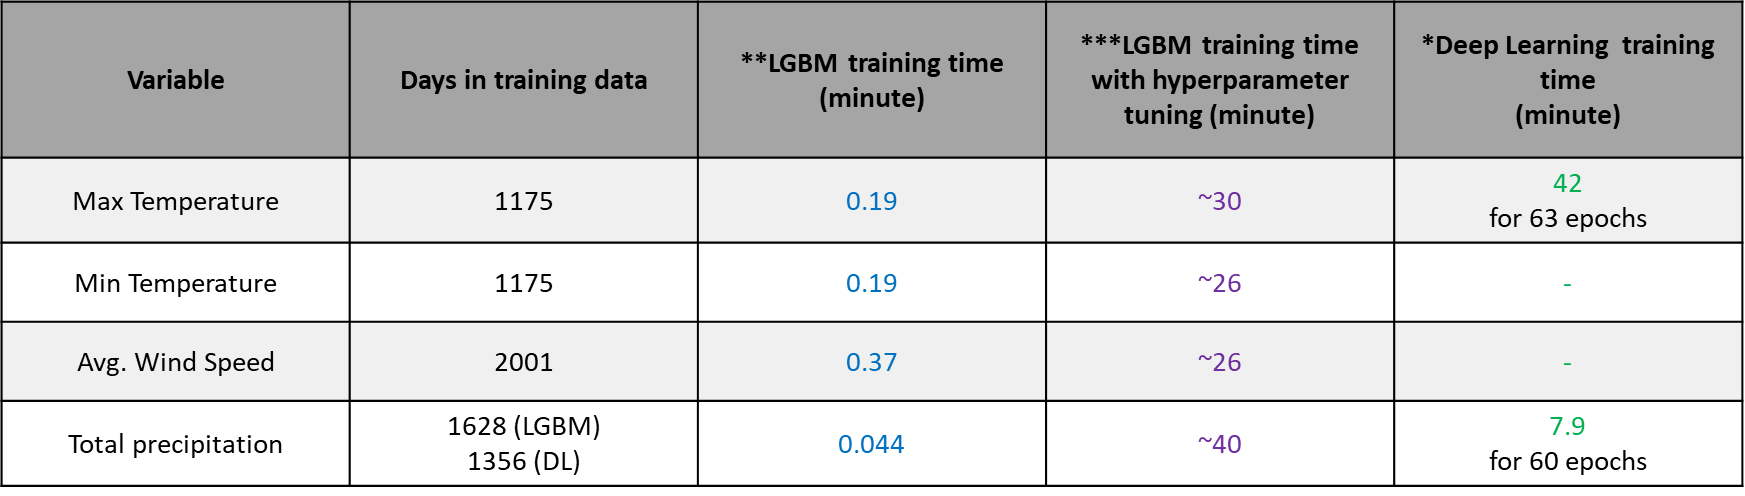

## Instances Used

- For ML (LGBM) models: ml.m5.4xlarge
- For DL (Pytorch) models: ml.p3.2xlarge

__Note:__ Initally I tuned the hyperparameters using ml.m5.4xlarge and it worked out fine. Afterwards it was causing issues. I am not sure why that happened but may be due to upate in the LGBM library itself. If ml.m5.4xlarge doesn't respond or slowly respond for hyperparameter tuning, use higher instances.

---------------------

# 6. Data splitting strategy

### `Randomized Date-based Split`
The training dataset were splitted into train-test (train-validation-test in case of DL models) dataset based on dates***. In this method, the unique dates in the compiled dataset were randomly permuted first. Then, a train-test ratio was assigned. After that, train-test datasets were splitted from the randomly permuted dates based on the  assigned ratio (referring as `randomized date-based split`). The train-test split was made based on randomly permuted dates rather than random splitting of the compiled dataset (in which there will be samples of pixels from all dates) because we wanted to check performances of the models on the test dates, which were totally unseen by the model during training phase. Note that, we only made tain-test split (instead of train-validation-test split) for the ML (LGBM) models because we tuned the model hyperparameters using 10-fold cross validation (CV) randomized grid search.


### Why `Randomized Date-based Split` instead of Randomized Split
For, ML and DL models, train-validation-test split is generally done using [sklearn train-test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. In our case, I tried it initially and the model performance was good also (except precipitation model). But the problem started while checking model performance for the test data. Our dataset is a daily time-series data. Under this usual/general randomized data splitting strategy, both train-test dataset had some pixels available in them from all the dates that were available for model training. Therefore, the model was being trained on pixels from all the dates. As a result, the performance on the testing dataset was very good because the model have already seen some pixels of all the dates. For understanding the `True` model performance, some dates needed to be totally unseen during model training. That's why we implemented the `randomized date-based split` strategy so that some dates are totally unseen by the model and we can understand model peroformance by looking into those dates.


### comment: train-validation-test split ratio
For Machine Learning (ML) GOSS model, the dataset was only splitted into train-test set only. Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV, and a total of 500 combinations of hyperparameters were tested. As hyperparameter optimization was performed using Randomized CV, we didn't split the data into any validation set during ML GOSS.

For Deep Learning (DL), the dataset was splitted into train-validation-test split as validation dataset was needed to track model training. 

Train-test ratio was chose between 80-20 or 70-30 based on model's performance. I used the test dataset to compare R2 of before and after modeling stage (boxplot shown in Section 7) to check model performance and used the train-test ratio that gave the best model performance. Train-validation-test set for DL models were chosen individually for each model (max temperature/total precipitation) based on training performance. For example, I kept track of training+validation loss to see which Train-validation-test ratio gives better model performance. For DL, Train-validation-test can be treated as a hyperparameter to chose the best slit ratio.


### comment: data splitting for `ML/DL Precip` model
We used the same `randomized date-based split` strategy for splitting the precipitation dataset for the ML/DL-based precipitation models. But while other models' performances were satisfactory, precipitation model didn't perform well despite the `randomized date-based split` strategy. One resaon behind that might be - compared to other weather datasets, precipitation training (observed) dataset is highly skewed with many zero values. 

According to [this article](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)'s very last plot, our precipitaion model is of unknown fit (our train-validation loss plot show similar trend), meaning that the validation dataset is easier for the model to predict than the training dataset. This might be happening due to the skewness of the dataset. It might be a good idea to look out for other data splitting methods that deals with skewed datasets.


-----------

# 7. Result Discussion



The `GOSS` (LightGBM) algorithm performs well for max/mi/averge temperature, average relative humidity, and average wind speed models. The train-test `R2` values are as follows-
1. __Max Temperature :__ Train- 0.989,  Test- 0.987
2. __Min Temperature :__ Train- 0.971,  Test- 0.960
3. __Avg Temperature :__ Train- 0.989,  Test- 0.987
4. __Avg Wind Speed :__ Train- 0.915,  Test- 0.896
5. __Avg Relative Humidity :__ Train- 0.948,  Test-0.940

The train-test R2 value comparison shows that there is no o
verfitting. The following table shows the models' performance on individual days on the test set.

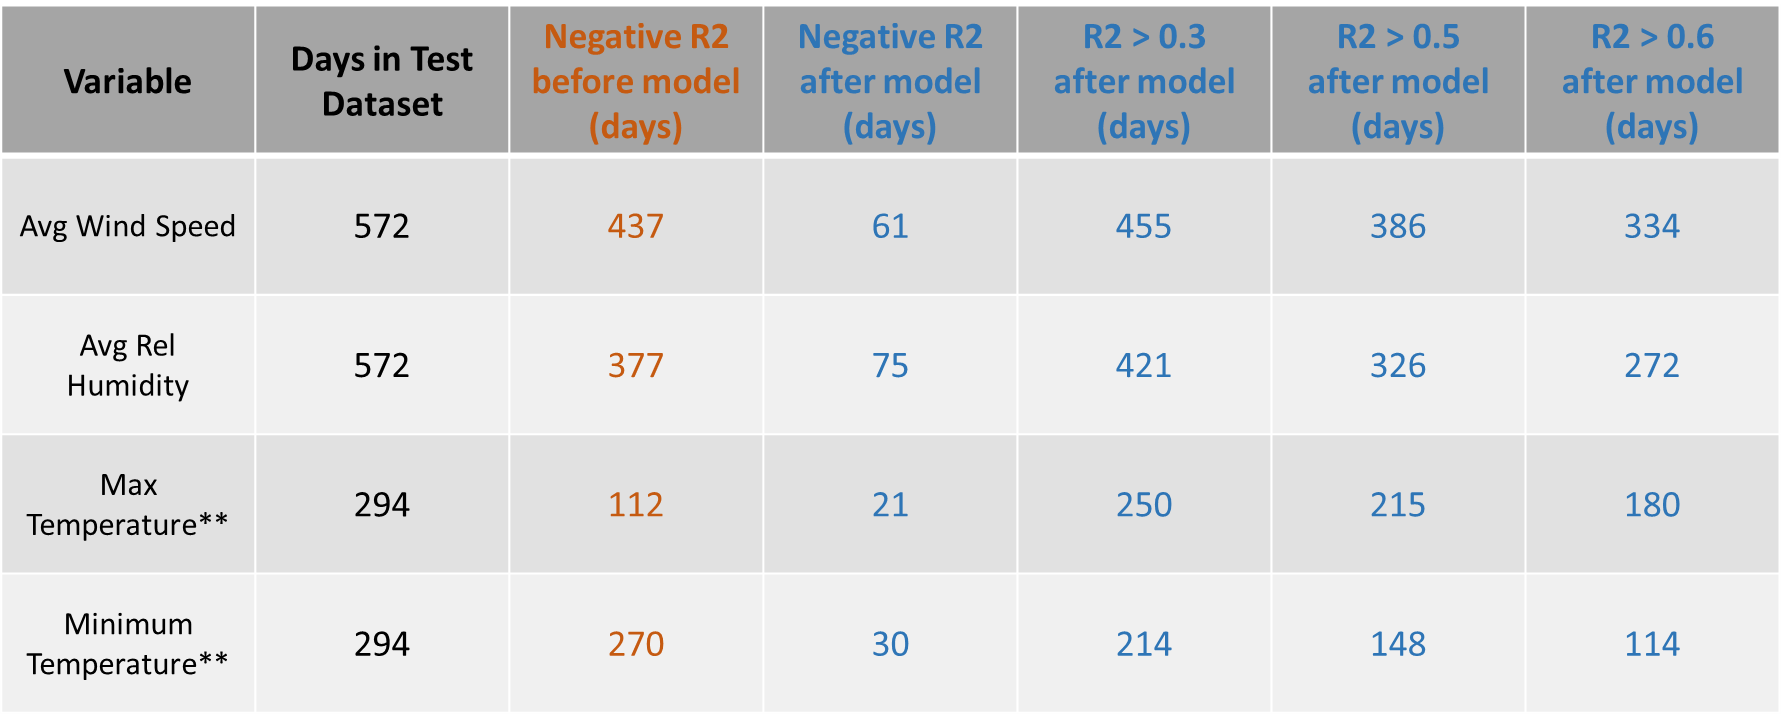

** **Max/Min Temperature model dataset was filtered for dates before Aug 2019 before performing 80-20 train-test data split.**

The boxplot shows improve in R2 values for individual days of the `test set` for `Average Relative Humidity` dataset.
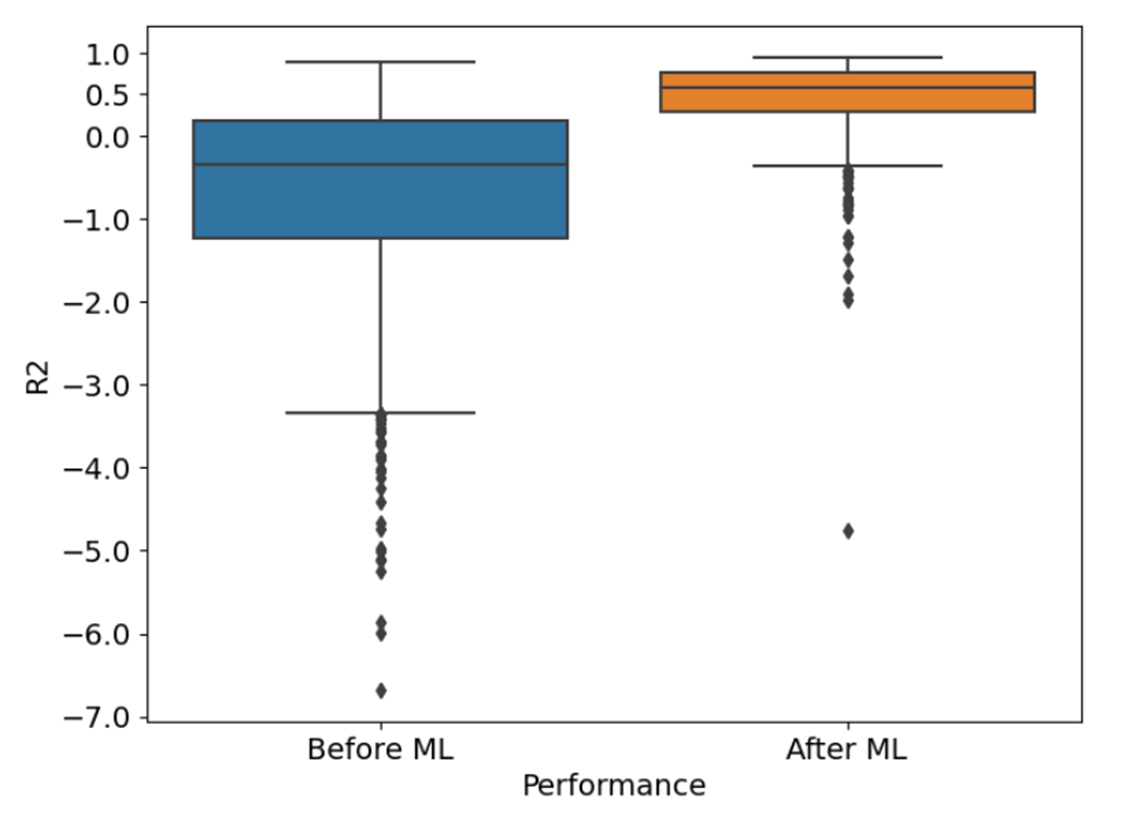

# 8. Performance of the precipitation model

Compared to the other weather models, the `total precipitation` model didn't do well. The GOSS algorithm overfits on the train data and gives poor perforamnce on the test set (train R2- 0.894, test R2- 0.496). Hyperparameter tuning of the GOSS model failed to remove overfitting. 
In the next step, we tried MLP to find out wheter that can remove overfitting and improve performance in predeicting precipitation. For detail, see `ML_DL_Total_precip` script. The MLP model for `total precipitation` didn't overfit. But the train-test set performance were not satisfactory (train R2- 0.582, test R2- 0.504). 


I  tried several things to improve the performance of the model-

### Things Tried to Improve Model Performance

#### Data
- __First, we tried to train the model with original ERA5 resampled weather datasets, topography, lat/lon, and month data. But that model wasn't performing well.__
- __Second, we tried incorporating improved input variables/predictors into the model. As improved weather variables, I replaced (see section 1 of the ML (GOSS) model) the original ERA5 resampled avg. wing speed, avg. relative humidity, min/max/avg temperature datasets with ML model improved/interpolated datasets (see the ML scripts in the folder). In this new input variable dataset, there are other variables, such as total_precipitation_era5, avg_Cloud, avg_atmPress, avg_dew_temp, max_Rhumid, max_atmPress, min_Rhumid, min_atmPress variables (resampled directly from ERA5 28km dataset), topographic variables (elavation, slope), lat/lon, and month. The topographic datasets have been interpolated directly from high resolution (30m) SRTM DEM data.__  
- Trained the model for the dataset spanning from Dec, 2015- July, 2019 as the precipitation data from Aug, 2019 have resolution issues. Also, tried training the model with the whole dataset spanning from Dec, 2015 - 2023. Performance for the model with timespan Dec, 2015- July, 2019  is better comparatively.


    
#### Model parameters    
- Tried different ratios of train-validation-test split. 
- The precipitation training data holds more precipitation values of zero and close to zeros than higher precipitation values, making the dataset imbalanced. Tried undersampling of precipitation training data to make the dataset balanced but it failed to improve performance.
- Tried different learning rates
- Tried simple and complex architecture
- Tried with/without dropout layer. Dropout value with 0.1 does better,
- Tried with/without early stopping. Early stopping does better.
- Tried different optimizers
   - for SGD: momentum 0.9, weight_decay 0.01, others default
   - for Adam: weight_decay 0.01, others default
- Tried different values of momentum and weight_decay

 

__Nothing worked out for the total precipitation model.__

## Future directions for precipitation model
- According to [this article](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)'s very last plot, our precipitaion model in of unknown fit, meaning that the validation dataset is easier for the model to predict than the training dataset. The following train-validation loss plot from MLP training shows the unknown fit of our model model. Precipitation datasets are highly skewed (more zero values than higher values) and our data splitting strategy `randomized date-based split` might not have worked well in this case. 

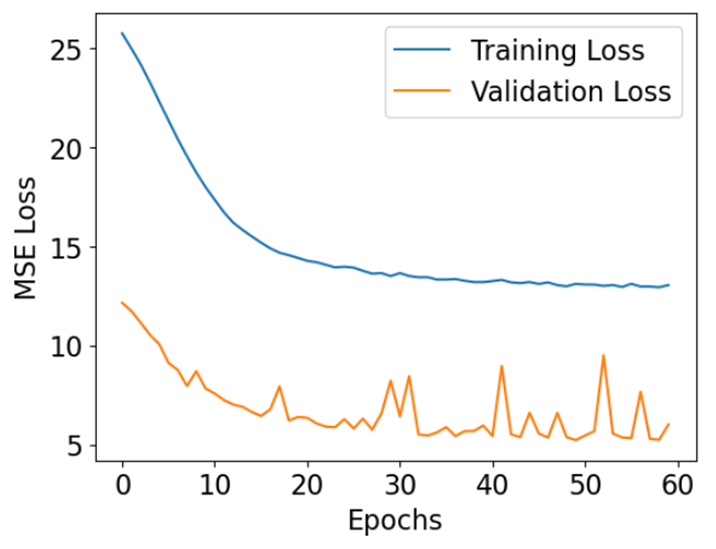
 
- Incorporate more datasets. We only used 4 years of data (2015-2019) for model training-validation-testing. As the precipitation training dataset if 8km resolution, the number of samples in the dataset is much lower than that of other weather models (the other weather models have datasets at 4km resolution, so more number of pixels available for training). It is recommended to incorporate more records to have better model performance.
- As the train-validation performance is not well, the model might have some missing physics. Moreover, there might be data quality issue in input and training data. Checking quality of input and training data is recommnded. 
- ERA5 datsets are also available at 10km resolution. Collection that datasets including weather variables from other models/satellites/sensors, such as MERRA-2, PRISM, GPM, and NOAA Stage IV radara data, and using them as input variables might increase model performance. 
- Many recent studies ([Wang et al. 2022](https://gmd.copernicus.org/articles/16/535/2023/gmd-16-535-2023-discussion.html), [Sha et al. 2020](https://journals.ametsoc.org/view/journals/apme/59/12/jamc-d-20-0057.1.xml), [Anh et al. 2019](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.6066)) use CNN/Unet based architectures for precipitation downscaling. Using such architectures might be a good idea.
    
- Exploring Sensor/Station data to discover insights.
